<a href="https://colab.research.google.com/github/trdykhuong/gemini_api/blob/main/examples/Browser_as_a_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up the SDK

In [2]:
%pip install -U -q 'google-genai'

from google import genai
genai.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 6.0 MB/s eta 0:00:00


'1.44.0'

Set up your API key

In [3]:
import os
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

Create the SDK client

In [4]:
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

LIVE_MODEL = 'gemini-2.0-flash-live-001'  # @param ['gemini-2.0-flash-live-001', 'gemini-live-2.5-flash-preview', 'gemini-2.5-flash-preview-native-audio-dialog', 'gemini-2.5-flash-exp-native-audio-thinking-dialog'] {allow-input: true, isTemplate: true}
MODEL = 'gemini-2.5-flash'  # @param ['gemini-2.5-flash'] {allow-input: true, isTemplate: true}

Define some helpers

In [5]:
import json
from urllib.robotparser import RobotFileParser
from urllib.parse import urlparse

from IPython.display import display, HTML, Markdown


def show_parts(r: types.GenerateContentResponse) -> None:
  """Helper for rendering a GenerateContentResponse object in IPython."""
  parts = r.candidates[0].content.parts
  if parts is None:
    finish_reason = r.candidates[0].finish_reason
    print(f'{finish_reason=}')
    return

  for part in parts:
    if part.text:
      display(Markdown(part.text))
    elif part.executable_code:
      display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    else:
      print(json.dumps(part.model_dump(exclude_none=True), indent=2))

  grounding_metadata = r.candidates[0].grounding_metadata
  if grounding_metadata and grounding_metadata.search_entry_point:
    display(HTML(grounding_metadata.search_entry_point.rendered_content))


def can_crawl_url(url: str, user_agent: str = "*") -> bool:
    """Look up robots.txt for a URL and determine if crawling is permissable.

    Args:
        url: The full URL to check.
        user_agent: The user agent to check, defaults to any UA.

    Returns:
        True if the URL can be crawled, False otherwise.
    """
    try:
      parsed_url = urlparse(url)
      robots_url = f"{parsed_url.scheme}://{parsed_url.netloc}/robots.txt"
      rp = RobotFileParser(robots_url)
      rp.read()

      return rp.can_fetch(user_agent, url)

    except Exception as e:
      print(f"Error checking robots.txt: {e}")
      return False  # Be a good citizen: fail closed.

# Browsing live


Use Google Search as a tool


In [6]:
config = {
    'response_modalities': ['TEXT'],
    'tools': [
        {'google_search': {}},
    ],
}


async def stream_response(stream, *, tool=None):
  """Handle a live streamed response, printing out text and issue tool calls."""
  all_responses = []

  async for msg in stream.receive():
    all_responses.append(msg)

    if text := msg.text:
      # Print streamed text responses.
      print(text, end='')

    elif tool_call := msg.tool_call:
      # Handle tool calls.
      for fc in tool_call.function_calls:
        print(f'< Tool call', fc.model_dump(exclude_none=True))

        if tool:
          # Call the tool.
          assert fc.name == tool.__name__, "Unknown tool call encountered"
          tool_result = tool(**fc.args)

        else:
          # Return 'ok' as a way to mock tool calls.
          tool_result = 'ok'

        tool_response = types.LiveClientToolResponse(
            function_responses=[types.FunctionResponse(
                name=fc.name,
                id=fc.id,
                response={'result': tool_result},
            )]
        )

        await stream.send(input=tool_response)

  return all_responses

In [7]:
async def run():
  async with client.aio.live.connect(model=LIVE_MODEL, config=config) as stream:

    await stream.send(input="Bài báo nổi bật trên Báo Tuổi Trẻ hôm nay là gì?", end_of_turn=True)
    await stream_response(stream)

await run()

/tmp/ipython-input-427872962.py:4: DeprecationWarning: The `session.send` method is deprecated and will be removed in a future version (not before Q3 2025).
Please use one of the more specific methods: `send_client_content`, `send_realtime_input`, or `send_tool_response` instead.
  await stream.send(input="Bài báo nổi bật trên Báo Tuổi Trẻ hôm nay là gì?", end_of_turn=True)


Dựa trên kết quả tìm kiếm từ Báo Tuổi Trẻ hôm nay, ngày 15 tháng 10 năm 2025, một số tin nổi bật bao gồm:

*   **Đường sắt tốc độ cao nối Cần Giờ của Vinspeed:** TP.HCM lập hội đồng thẩm định dự án.
*   **Giá vàng thế giới:** Vượt 4.200 USD/ounce, vàng miếng SJC lên 148 triệu đồng/lượng.
*   **Campuchia công bố danh tính** nghi phạm người Trung Quốc tra tấn, sát hại nam sinh Hàn Quốc.
*   **Hàn Quốc cấm công dân** đến 3 "điểm đen" ở Campuchia.
*   **Hà Nội mở đợt thi đua cao điểm** chào mừng Đại hội lần thứ XIV của Đảng.
*   **TP Hồ Chí Minh bắt tay hành động** vì mục tiêu chung.



Add a live browser

In [8]:
%pip install -q markdownify

In [9]:
import requests

import markdownify


def load_page(url: str) -> str:
  """
  Load the page contents as Markdown.
  """

  if not can_crawl_url(url):
    return f"URL {url} failed a robots.txt check."

  try:
    page = requests.get(url)
    return markdownify.markdownify(page.content)

  except Exception as e:
    return f"Error accessing URL: {e}"

In [36]:
load_page_def = types.Tool(functionDeclarations=[
    types.FunctionDeclaration.from_callable(client=client, callable=load_page)]).model_dump(exclude_none=True)

config = {
    'response_modalities': ['TEXT'],
    'tools': [
        load_page_def,
    ],
    'system_instruction': """Your job is to answer the users query using the tools available.

First determine the address that will have the information and tell the user. Then immediately
invoke the tool. Then answer the user.
"""
}


async def run():
  async with client.aio.live.connect(model=LIVE_MODEL, config=config) as stream:

    await stream.send(input="Bài báo nổi bật trên trang Báo Thanh Niên ngày hôm nay?", end_of_turn=True)
    await stream_response(stream, tool=load_page)

await run()

/tmp/ipython-input-3924623922.py:20: DeprecationWarning: The `session.send` method is deprecated and will be removed in a future version (not before Q3 2025).
Please use one of the more specific methods: `send_client_content`, `send_realtime_input`, or `send_tool_response` instead.
  await stream.send(input="Bài báo nổi bật trên trang Báo Thanh Niên ngày hôm nay?", end_of_turn=True)


Để tôi tìm bài viết nổi bật trên trang Báo Thanh Niên cho bạn. Địa chỉ để tìm thông tin này là trang web của Báo Thanh Niên.



< Tool call {'id': 'function-call-8561657773220650095', 'args': {'url': 'https://thanhnien.vn/'}, 'name': 'load_page'}


/tmp/ipython-input-1116631210.py:42: DeprecationWarning: The `session.send` method is deprecated and will be removed in a future version (not before Q3 2025).
Please use one of the more specific methods: `send_client_content`, `send_realtime_input`, or `send_tool_response` instead.
  await stream.send(input=tool_response)


Dựa trên thông tin từ trang Báo Thanh Niên, một số bài viết nổi bật hiện tại bao gồm:

*   **Khám xét nhà Ngân 98, thu giữ 80 sổ đỏ, hơn 8.000 USD**
*   **Đề xuất biến động tài sản 1 tỉ đồng/năm phải kê khai**
*   **Báo Thanh Niên sẽ trao 400 triệu đồng tại giải pickleball Cùng con đi tiếp cuộc đời - tranh cúp PASSION002**
*   **Đà Nẵng \'siết\' chống rửa tiền trong lĩnh vực bất động sản**
*   **Vingroup ra mắt \'Cộng đồng hưu trí\' đẳng cấp quốc tế đầu tiên tại Việt Nam**
*   **Robot Trung Quốc gắn logo ĐH Bách khoa Hà Nội: \'Chỉ đơn giản là đánh dấu tài sản\'**

Bạn có muốn biết thêm chi tiết về bất kỳ bài viết nào trong số này không?

Browse pages visually


In [11]:
!apt install -y chromium-browser

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apparmor libfuse3-3 libudev1 snapd squashfs-tools systemd-hwe-hwdb udev
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
The following NEW packages will be installed:
  apparmor chromium-browser libfuse3-3 snapd squashfs-tools systemd-hwe-hwdb
  udev
The following packages will be upgraded:
  libudev1
1 upgraded, 7 newly installed, 0 to remove and 37 not upgraded.
Need to get 34.1 MB of archives.
After this operation, 134 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 apparmor amd64 3.0.4-2ubuntu2.4 [598 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 squashfs-tools amd64 1:4.5-3build1 [159 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libudev1 amd64 249.11-0ubuntu3.17 [76.7 kB]
Get:4 http://archive.ubuntu.com/

In [12]:
%pip install -q selenium webdriver-manager

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.7/512.7 kB 33.9 MB/s eta 0:00:00


Define a graphical browser

In [13]:
import time
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

SCREENSHOT_FILE = 'screenshot.png'


def browse_url(url: str) -> str:
    """Captures a screenshot of the webpage at the provided URL.

    A graphical browser will be used to connect to the URL provided,
    and generate a screenshot of the rendered web page.

    Args:
        url: The full absolute URL to browse/screenshot.

    Returns:
        "ok" if successfully captured, or any error messages.
    """
    if not can_crawl_url(url):
      return f"URL {url} failed a robots.txt check."

    try:
      chrome_options = webdriver.ChromeOptions()
      chrome_options.add_argument('--headless')
      chrome_options.add_argument('--no-sandbox')
      chrome_options.headless = True
      driver = webdriver.Chrome(options=chrome_options)

      # Take one large image, 2x high as it is wide. This should be enough to
      # capture most of a page's interesting info, and should capture anything
      # designed "above the fold", without going too deep into things like
      # footer links, infinitely scrolling pages, etc.
      # Otherwise multiple images are needed, which requires waiting, scrolling
      # and stitching, and introduces lag that slows down interactions.
      driver.set_window_size(1024, 2048)
      driver.get(url)

      # Wait for the page to fully load.
      time.sleep(5)
      driver.save_screenshot(SCREENSHOT_FILE)

      print(f"Screenshot saved to {SCREENSHOT_FILE}")
      return markdownify.markdownify(driver.page_source)

    except Exception as e:
      print(f"An error occurred: {e}")
      return str(e)

    finally:
      # Close the browser
      if driver:
        driver.quit()


url = "https://en.wikipedia.org/wiki/Castle"
browse_url(url);

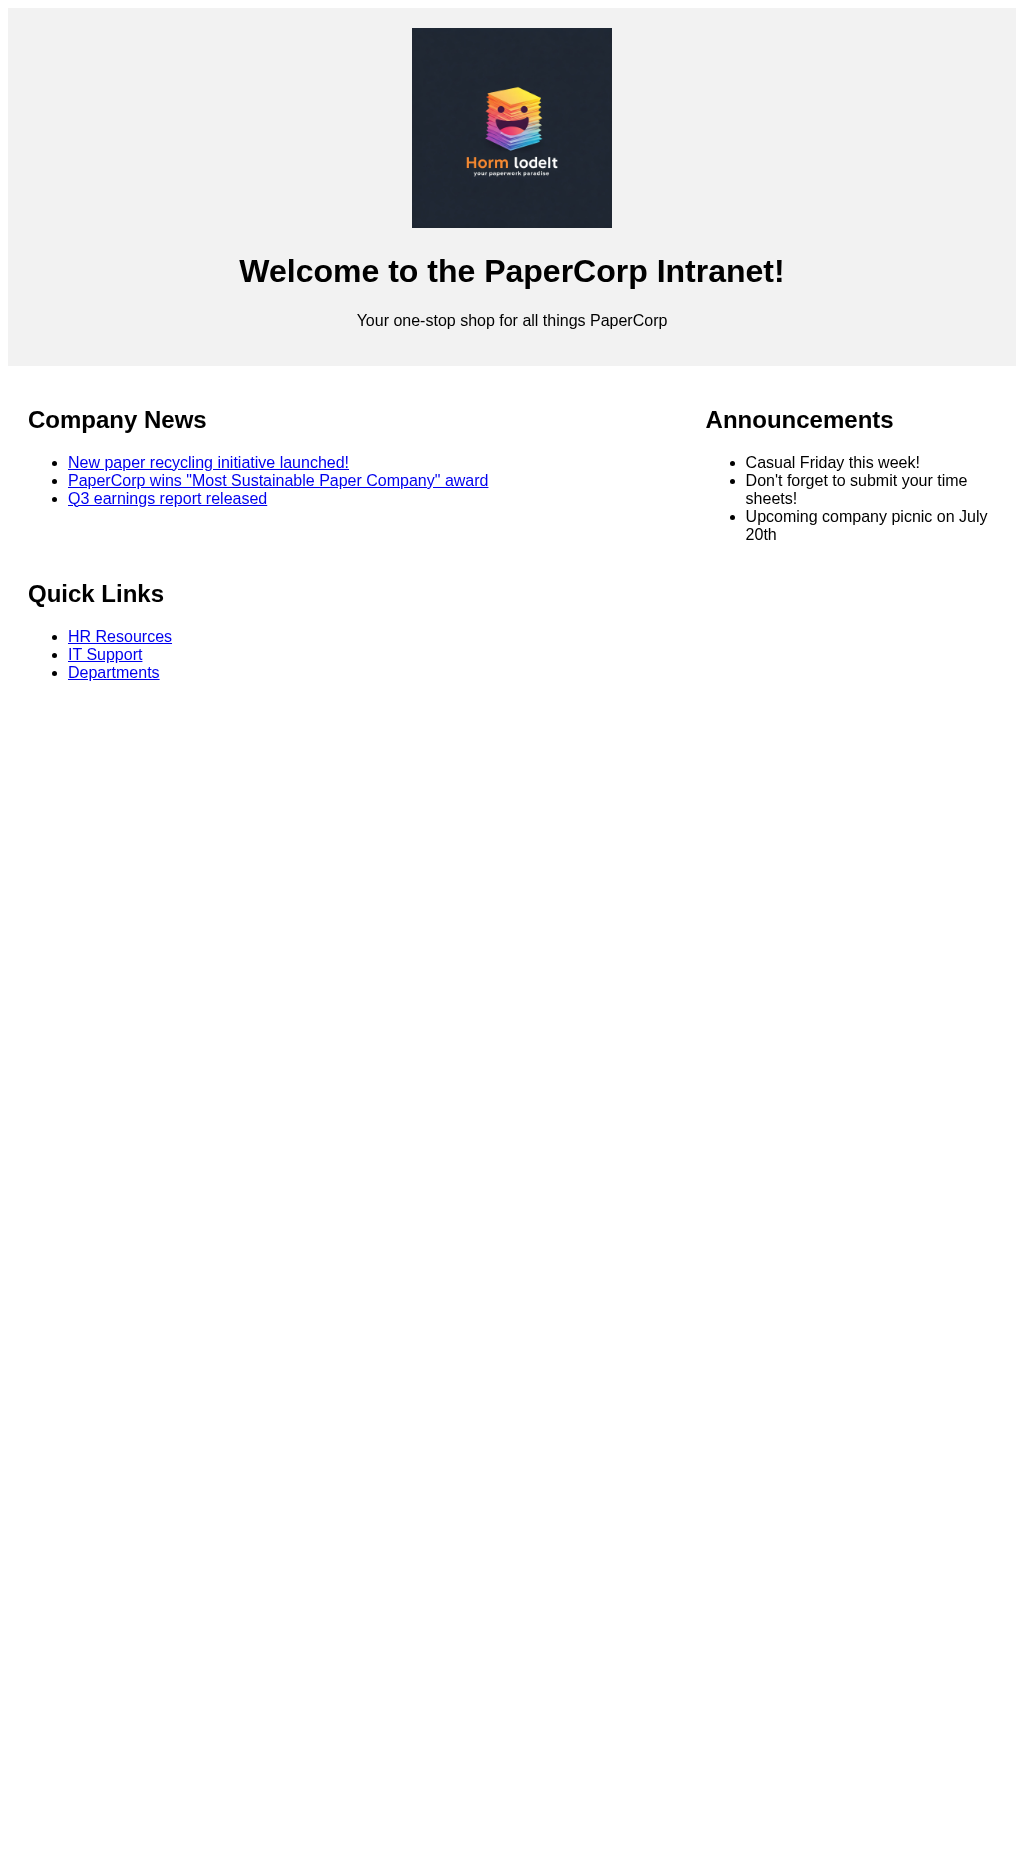

In [28]:
from IPython.display import Image

Image('screenshot.png')

Connect the browser to the model

In [32]:
sys_int = """You are a system with access to websites via the `browse_url` tool.
Use the `browse_url` tool to browse a URL and generate a screenshot that will be
returned for you to see and inspect, like using a web browser.

When a user requests information, first use your knowledge to determine a specific
page URL, tell the user the URL and then invoke the `browse_tool` with this URL. The
tool will supply the website, at which point you will examine the contents of the
screenshot to answer the user's questions. Do not ask the user to proceed, just act.

You will not be able to inspect the page HTML, so determine the most specific page
URL, rather than starting navigation from a site's homepage.
"""

# Because `browse_url` generates an image, and images can't be used in function calling
# (but can be used in regular Content/Parts), automatic function calling can't be used and
# the tool must be specified explicitly, and handled manually.
browse_tool = types.Tool(functionDeclarations=[
    types.FunctionDeclaration.from_callable(client=client, callable=browse_url)])

chat = client.chats.create(
    model=MODEL,
    config={'tools': [browse_tool], 'system_instruction': sys_int})

r = chat.send_message('Search the key word "trending" on Youtube?')
show_parts(r)

I will navigate to the YouTube trending page.


{
  "function_call": {
    "args": {
      "url": "https://www.youtube.com/feed/trending"
    },
    "name": "browse_url"
  }
}


In [33]:
import PIL

response_parts = []

# For each function call, generate the response in two parts. Once for the
# function response, and one for the image as regular content. This simulates
# the function "returning" an image to the model as part of a function call.
for p in r.candidates[0].content.parts:
  if fn := p.function_call:
    assert fn.name == 'browse_url'

    url = fn.args['url']
    print(url)
    response = browse_url(url)
    print(response)

    img = PIL.Image.open(SCREENSHOT_FILE)

    fr = genai.types.Part(function_response=genai.types.FunctionResponse(
        name=fn.name,
        id=fn.id,
        response={'result': response},
    ))
    response_parts.extend([fr, img])

https://www.youtube.com/feed/trending
Screenshot saved to screenshot.png
Home - YouTube

Back



[![]()](/ "YouTube Home")

Skip navigation

Search

Search with your voice

[Sign in](https://accounts.google.com/ServiceLogin?service=youtube&uilel=3&passive=true&continue=https%3A%2F%2Fwww.youtube.com%2Fsignin%3Faction_handle_signin%3Dtrue%26app%3Ddesktop%26hl%3Den%26next%3Dhttps%253A%252F%252Fwww.youtube.com%252Ffeed%252Ftrending&hl=en&ec=65620)

[![]()](/ "YouTube Home")



[Home


Home](/ "Home")
Shorts


Shorts
[Subscriptions


Subscriptions](/feed/subscriptions "Subscriptions")
[You


You](/feed/you "You")
[History


History](/feed/history "History")















![]()

Try searching to get started

Start watching videos to help us build a feed of videos you'll love.

Search

Info

Shopping

Tap to unmute

2x

![]()

If playback doesn't begin shortly, try restarting your device.

![]()

•

You're signed out

Videos you watch may be added to the TV's watch history and influence TV r

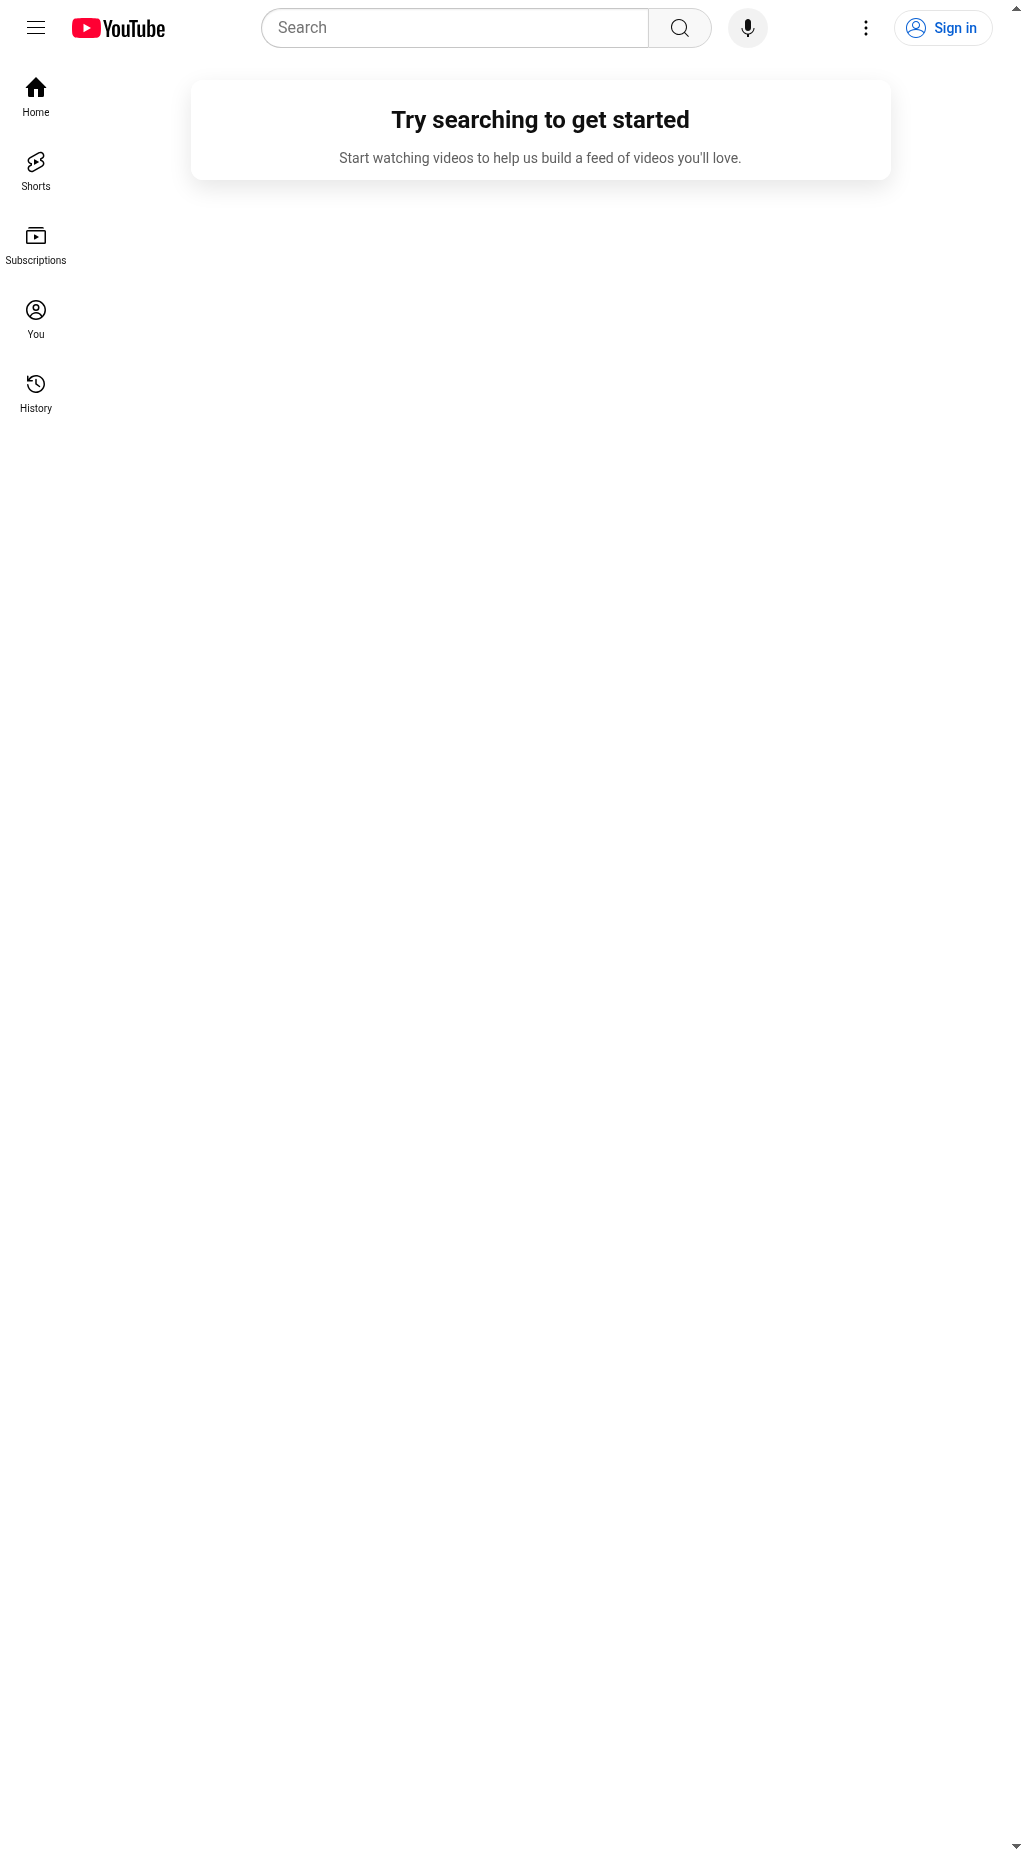

In [34]:
Image(SCREENSHOT_FILE)

In [35]:
r2 = chat.send_message(response_parts)
show_parts(r2)

I have browsed to the YouTube trending page. However, it appears that the page is asking me to sign in and suggests "Try searching to get started" and "Start watching videos to help us build a feed of videos you'll love." This indicates that the trending feed is personalized and requires a signed-in user or previous watch history. As I am not signed in, I cannot see the trending videos directly.

# Browse local services

In [19]:
!wget -nv https://storage.googleapis.com/generativeai-downloads/data/intranet.zip
!unzip intranet.zip

2025-10-15 16:58:22 URL:https://storage.googleapis.com/generativeai-downloads/data/intranet.zip [168843/168843] -> "intranet.zip" [1]
Archive:  intranet.zip
   creating: intranet/
  inflating: intranet/logo.png       
  inflating: intranet/index.html     
  inflating: intranet/it.html        
  inflating: intranet/news.html      
  inflating: intranet/sitemap.xml    
  inflating: intranet/departments.html  
  inflating: intranet/hr.html        
 extracting: intranet/robots.txt     


In [20]:
import http.server
import os
import socketserver
import threading


PORT = 80
DIRECTORY = "./intranet/"

class Handler(http.server.SimpleHTTPRequestHandler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, directory=DIRECTORY, **kwargs)


httpd = socketserver.TCPServer(("", PORT), Handler)
server_thread = threading.Thread(target=httpd.serve_forever)
server_thread.start()

In [21]:
!echo "127.0.0.1 papercorp" >> /etc/hosts
!curl http://papercorp:{PORT}/

<!DOCTYPE html>
<!--
Copyright 2025 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
-->
<html>
<head>
  <title>Welcome to PaperCorp Intranet</title>
  <style>
    body {
      font-family: sans-serif;
    }
    .header {
      background-color: #f2f2f2;
      padding: 20px;
      text-align: center;
    }
    .logo {
      max-width: 200px;
    }
    .content {
      padding: 20px;
    }
    .news {
      float: left;
      width: 60%;
    }
    .announcements {
      float: right;
      width: 30%;
    }


127.0.0.1 - - [15/Oct/2025 16:58:30] "GET / HTTP/1.1" 200 -


127.0.0.1 - - [15/Oct/2025 16:58:33] "GET /robots.txt HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2025 16:58:44] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2025 16:58:44] "GET /logo.png HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2025 16:58:44] code 404, message File not found
127.0.0.1 - - [15/Oct/2025 16:58:44] "GET /favicon.ico HTTP/1.1" 404 -


Screenshot saved to screenshot.png
Welcome to PaperCorp Intranet



![PaperCorp Logo](logo.png)

Welcome to the PaperCorp Intranet!

Your one-stop shop for all things PaperCorp

Company News
------------

* [New paper recycling initiative launched!](news.html)
* [PaperCorp wins "Most Sustainable Paper Company" award](news.html)
* [Q3 earnings report released](news.html)

Announcements
-------------

* Casual Friday this week!
* Don't forget to submit your time sheets!
* Upcoming company picnic on July 20th

Quick Links
-----------

* [HR Resources](hr.html)
* [IT Support](it.html)
* [Departments](departments.html)


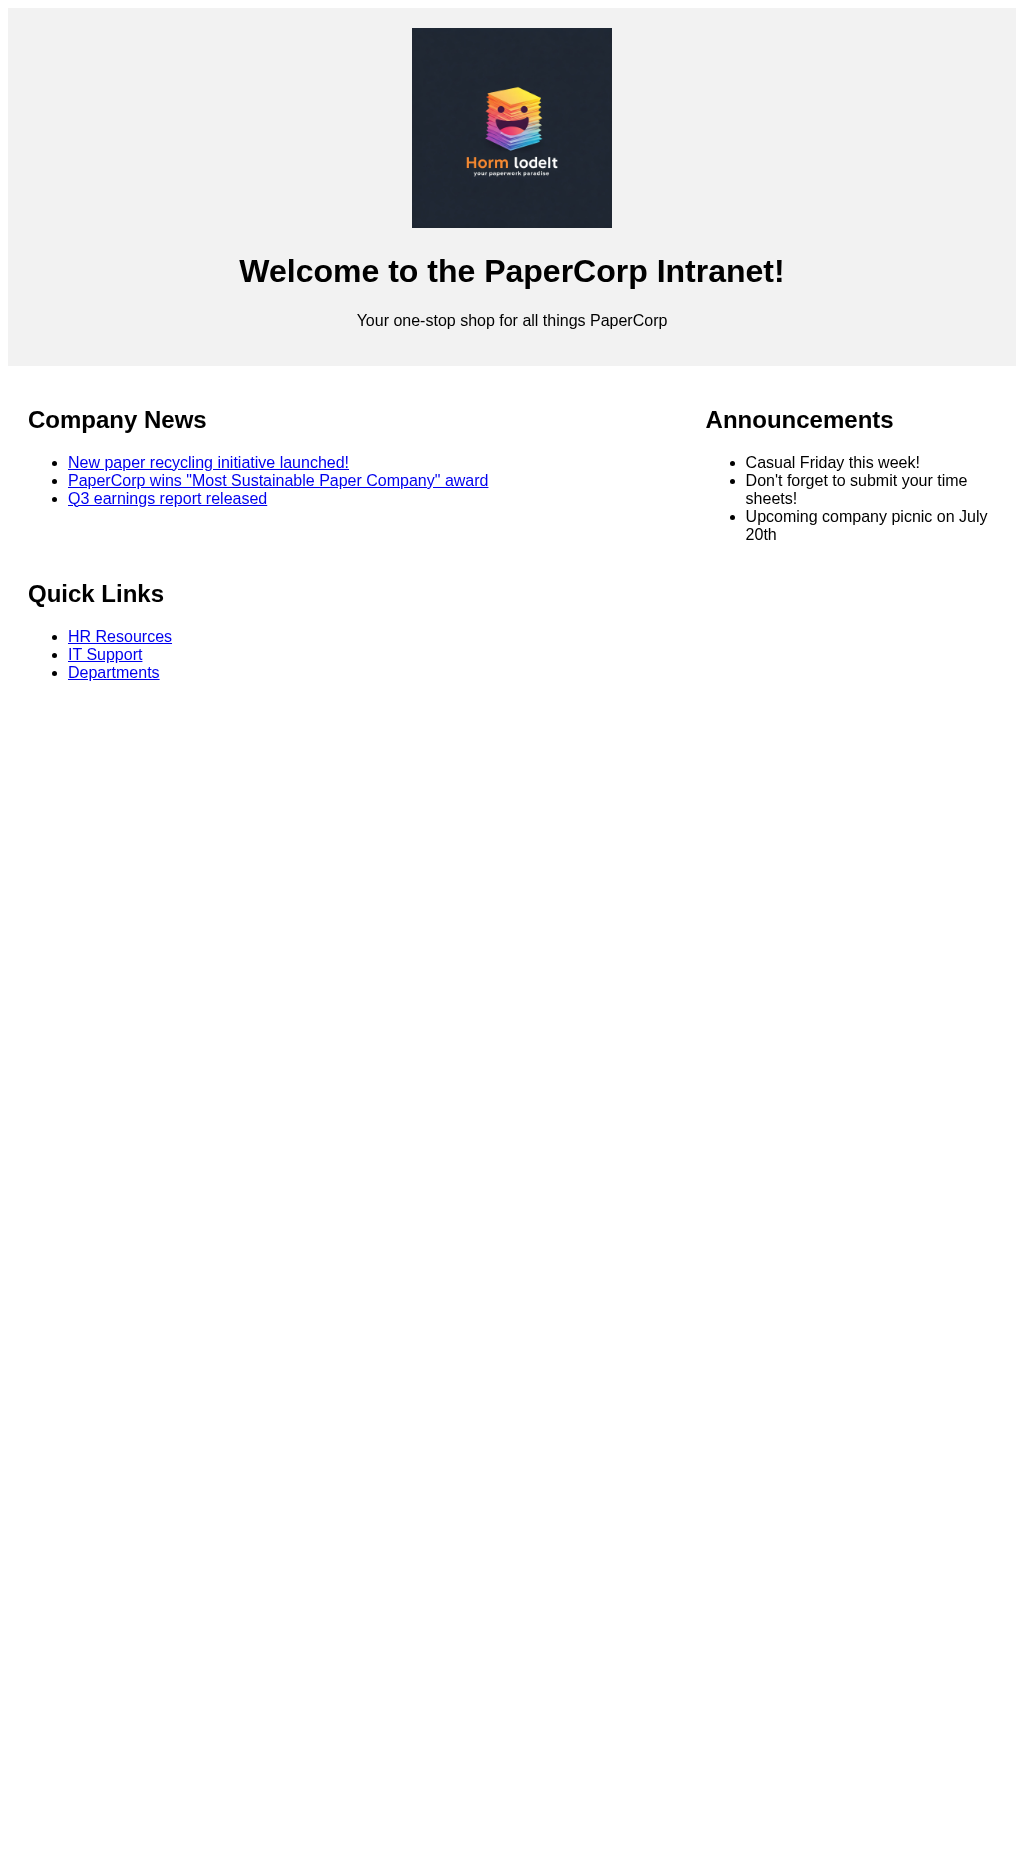

In [22]:
import PIL

print(browse_url(f"http://papercorp:{PORT}/"))
PIL.Image.open(SCREENSHOT_FILE)

In [23]:
config = {
    'system_instruction': """Use the tools you have to answer the user's questions about
the "PaperCorp" company.

You have access to web pages through the `load_page` tool, including access to the local
network and intranet, where you will find information about the company. The `load_page`
tool will return you the page contents as Markdown.

The intranet hostname is `papercorp`, and the home page can be accessed via
http://papercorp/.

Unless you know an address already, start navigating from the home page to find other
pages.
""",
    'tools': [load_page],
}

chat = client.chats.create(model=MODEL, config=config)
r = chat.send_message('What forms are available through HR?')
show_parts(r)

127.0.0.1 - - [15/Oct/2025 16:59:07] "GET /robots.txt HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2025 16:59:07] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2025 16:59:08] "GET /robots.txt HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2025 16:59:08] "GET /hr.html HTTP/1.1" 200 -


The following forms are available through HR:
*   Expense Report Form
*   Time Off Request Form
*   Benefits Enrollment Form
*   Tax Forms (W-2, etc.)

In [24]:
httpd.shutdown()
httpd.server_close()